BIDIRECTIONAL LSTM FOR 1 FEATURE DURATION 24 HOURS

In [1]:
num_feature = 1

Importing library

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Bidirectional, LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

Importing data

In [3]:
filename = '../data/07-09-2023.csv'
data = []
with open(filename, 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        data.append(row)
        
df = pd.DataFrame(data)
df.columns = ["Record_ID","Time","Timestamp","Temperature","Disolved Oxygen","Salinity","pH","Turbidity"]
df['Record_ID'] = df["Record_ID"].astype(int)
df['Time'] = df["Time"].astype(str)
df['Temperature'] = df["Temperature"].astype(float)
df['Disolved Oxygen'] = df["Disolved Oxygen"].astype(float)
df['Salinity'] = df["Salinity"].astype(float)
df['pH'] = df["pH"].astype(float)
df['Turbidity'] = df["Turbidity"].astype(float)
df['Time'] = pd.to_datetime(df['Time'],format="%d/%m/%Y %H:%M:%S")
df.set_index('Time', inplace=True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.describe()

Record_ID   Temperature  Disolved Oxygen       Salinity  \
count  216701.000000  2.165460e+05     2.165460e+05  216546.000000   
mean   510658.553103 -1.045808e+03    -1.066890e+03      28.388756   
std    275942.121296  3.531911e+05     3.531911e+05     353.514121   
min         1.000000 -1.162173e+08    -1.162173e+08 -116217.300000   
25%    274897.000000  2.540000e+01     5.000000e+00      31.300000   
50%    647845.000000  2.810000e+01     6.600000e+00      35.500000   
75%    716179.000000  2.960000e+01     7.500000e+00      35.700000   
max    843807.000000  4.430000e+01     2.972360e+04      47.800000   

                 pH     Turbidity  
count  2.165460e+05  2.165460e+05  
mean  -1.066845e+03 -8.721180e+02  
std    3.531911e+05  3.531925e+05  
min   -1.162173e+08 -1.162173e+08  
25%    6.600000e+00  1.380000e+01  
50%    7.200000e+00  2.810000e+01  
75%    7.800000e+00  8.200000e+01  
max    7.190000e+01  1.089990e+04

In [4]:
temp = df['Temperature']
temp = temp[temp>=18]
temp = temp.resample('H').mean()

Splitting train and test data

In [5]:
train = temp[(temp.index.year<2022) | ((temp.index.year==2022)&(temp.index.month<9))]
test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]

Observe data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


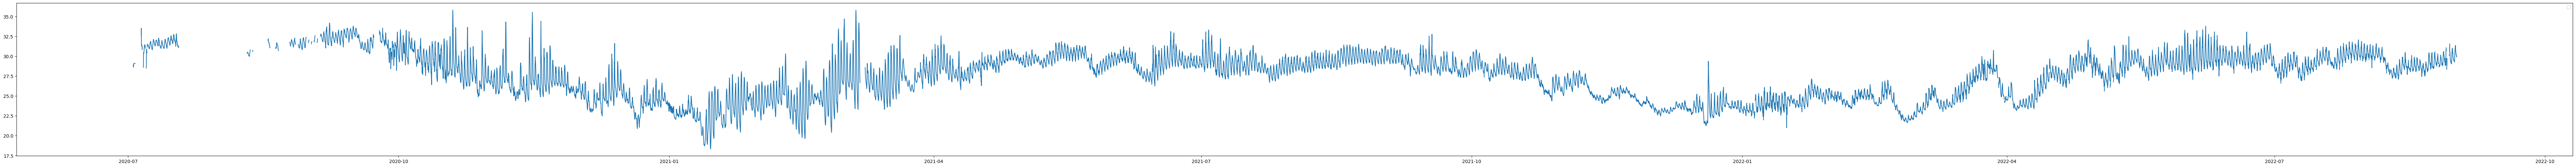

In [6]:
plt.figure(figsize=(100,6))
plt.plot(train.index,train.to_numpy().ravel())
plt.legend()
plt.show()

In [7]:
# train.resample('D').agg(['mean', 'sum', 'std']).plot(subplots = True, title='Temperature resampled over day', color='red')
# plt.show()

In [8]:
# train.resample('M').mean().plot(kind='bar')
# plt.ylabel('Temperature')
# plt.title('Temperature per month (averaged over month)')
# plt.show()

Function Prepare training data

In [9]:
def split_train(array: np.array, duration: int):
    x = np.empty((0,duration))
    y = np.empty((0,1))
    for i in range(array.shape[0]-duration-1):
        new_row_x = array[i:i+duration].reshape(1, duration)
        new_row_y = array[i+duration].reshape(1, 1)
        if (np.any(np.isnan(new_row_x)) or np.any(np.isnan(new_row_y))): continue
        else:
            x = np.concatenate((x,new_row_x),axis=0)
            y = np.concatenate((y,new_row_y),axis=0)
    return x.reshape(x.shape[0],x.shape[1],num_feature), y.reshape(y.shape[0],1)

Bidirectional LSTM

Bidirect-LSTM_24h_1feature_64node

In [10]:
time_step = 24

In [11]:
x_train, y_train = split_train(train.to_numpy(),time_step)

Create and train model

In [12]:
# model_1 = Sequential()
# model_1.add(Bidirectional(LSTM(64,activation='relu', input_shape=(time_step,num_feature))))
# model_1.add(Dense(1))
# model_1.compile(optimizer='adam', loss='mse')
# model_1.build(input_shape=(1,time_step,num_feature))
# model_1.summary()
# model_1.fit(x_train, y_train, epochs=10)
# model_1.save('../model/Bidirect-LSTM_24h_1feature_64node.h5')

Load model

In [13]:
model_1 = load_model('../model/Bidirect-LSTM_24h_1feature_64node.h5')
model_1.build(input_shape=(1,time_step,num_feature))
model_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirect  (None, 256)               133120    
 ional)                                                          
                                                                 
 dense_12 (Dense)            (None, 1)                 257       
                                                                 
Total params: 133377 (521.00 KB)
Trainable params: 133377 (521.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Test model

In [14]:
x_test, y_test = split_train(test.to_numpy(),time_step)
y_predict = np.array(model_1.predict(x_test))
y_test = y_test.ravel()
y_predict = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

267/267 [==============================] - 3s 10ms/step
Mean Squared Error (MSE): 0.17904556808689132
Mean Absolute Error (MAE): 0.26803869205662556


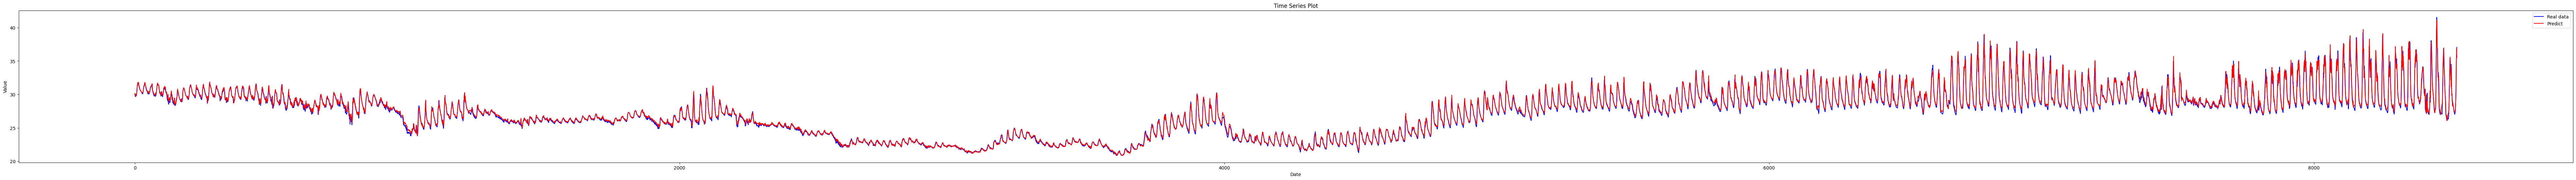

In [15]:
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

Bidirect-LSTM_48h_1feature_64node

In [16]:
time_step = 48

In [17]:
x_train, y_train = split_train(train.to_numpy(),time_step)

Create and train model

In [18]:
# model_2 = Sequential()
# model_2.add(Bidirectional(LSTM(64,activation='relu', input_shape=(time_step,num_feature))))
# model_2.add(Dense(1))
# model_2.compile(optimizer='adam', loss='mse')
# model_2.build(input_shape=(1,time_step,num_feature))
# model_2.summary()
# model_2.fit(x_train, y_train, epochs=10)
# model_2.save('../model/Bidirect-LSTM_48h_1feature_64node.h5')

Load model

In [19]:
model_2 = load_model('../model/Bidirect-LSTM_48h_1feature_64node.h5')
model_2.build(input_shape=(1,time_step,num_feature))
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirect  (None, 128)               33792     
 ional)                                                          
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 33921 (132.50 KB)
Trainable params: 33921 (132.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Test model

In [20]:
x_test, y_test = split_train(test.to_numpy(),time_step)
y_predict = np.array(model_2.predict(x_test))
y_test = y_test.ravel()
y_predict = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

263/263 [==============================] - 4s 13ms/step
Mean Squared Error (MSE): 1.116336763482131
Mean Absolute Error (MAE): 0.7887723837793936


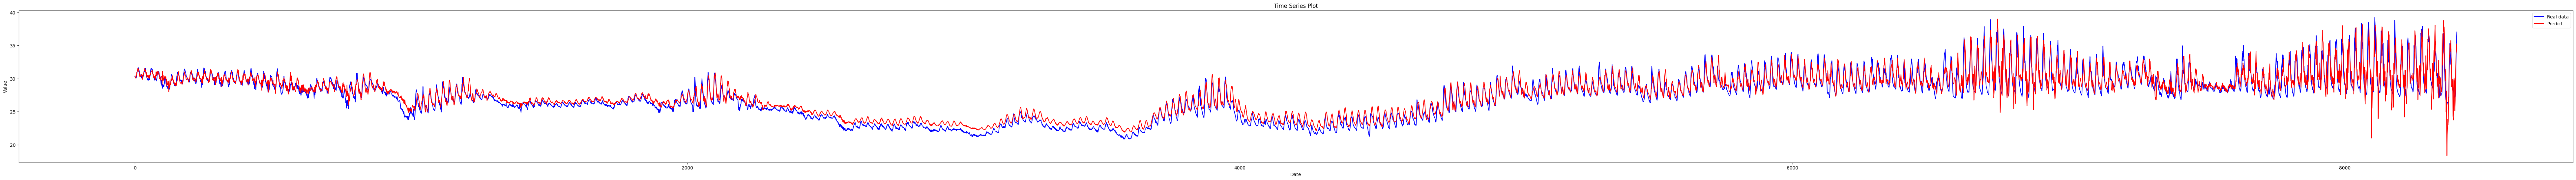

In [21]:
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

Bidirect-LSTM_24h_1feature_128node

In [22]:
time_step = 24

In [23]:
x_train, y_train = split_train(train.to_numpy(),time_step)

Create and train model

In [24]:
# model_3 = Sequential()
# model_3.add(Bidirectional(LSTM(128,activation='relu', input_shape=(time_step,num_feature))))
# model_3.add(Dense(1))
# model_3.compile(optimizer='adam', loss='mse')
# model_3.build(input_shape=(1,time_step,num_feature))
# model_3.summary()
# model_3.fit(x_train, y_train, epochs=10)
# model_3.save('../model/Bidirect-LSTM_24h_1feature_128node.h5')

Load model

In [25]:
model_3 = load_model('../model/Bidirect-LSTM_24h_1feature_128node.h5')
model_3.build(input_shape=(1,time_step,num_feature))
model_3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 64)                8704      
 ional)                                                          
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8769 (34.25 KB)
Trainable params: 8769 (34.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Test model

In [26]:
x_test, y_test = split_train(test.to_numpy(),time_step)
y_predict = np.array(model_3.predict(x_test))
y_test = y_test.ravel()
y_predict = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

267/267 [==============================] - 2s 5ms/step
Mean Squared Error (MSE): 0.3120798512120373
Mean Absolute Error (MAE): 0.3590295587076317


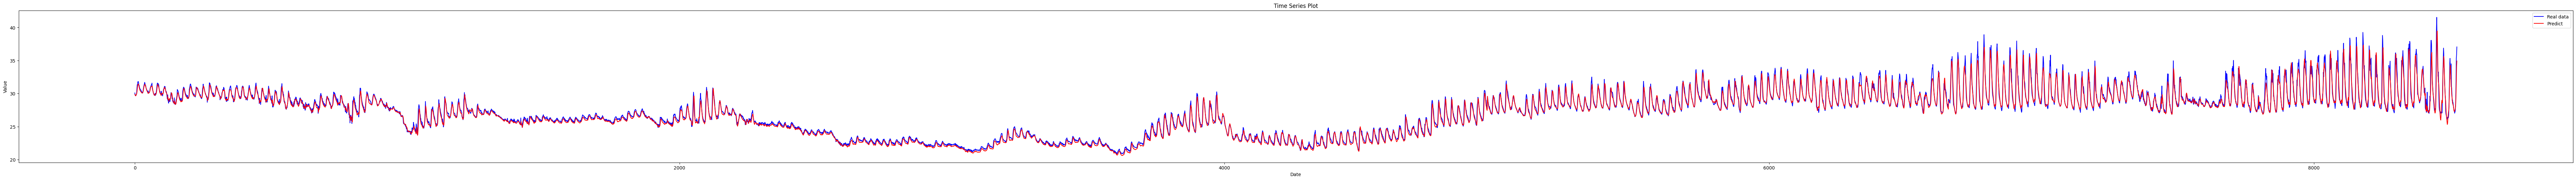

In [27]:
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

XGBoost

XGBoost 24 hours 24 max depth

In [28]:
time_step = 24

In [29]:
x_train, y_train = split_train(train.to_numpy(),time_step)
x_test, y_test = split_train(test.to_numpy(),time_step)

In [30]:
x_train = x_train.reshape(-1,time_step)
y_train = y_train.reshape(-1)
x_test = x_test.reshape(-1,time_step)
y_test = y_test.reshape(-1)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:359

Mean Squared Error (MSE): 0.2908993760563318
Mean Absolute Error (MAE): 0.28658493109345373


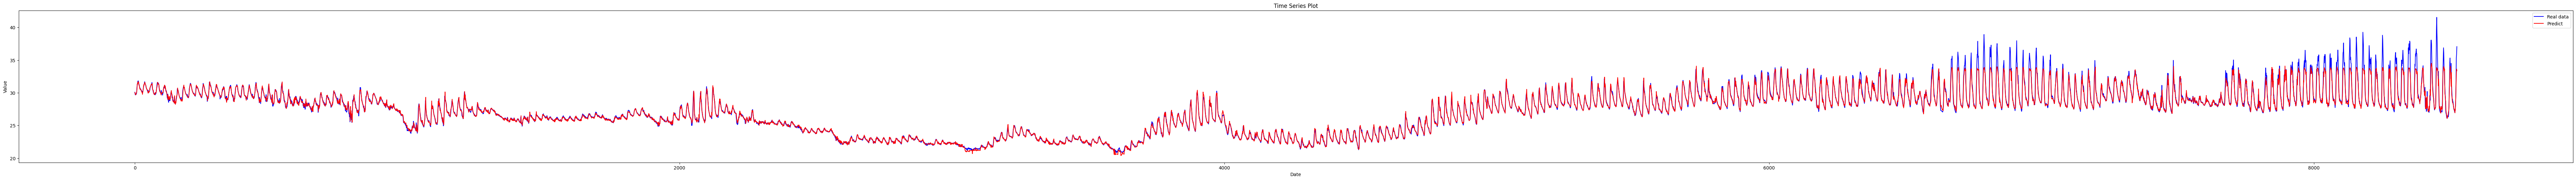

In [31]:
params = {
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'max_depth': 24,
    'learning_rate': 0.1,
    'subsample': 0.8
}
model_4 = xgb.XGBRegressor(**params)
model_4.fit(x_train,y_train)
y_predict = model_4.predict(x_test)
y_predict  = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

XGBoost 48 hours 24 max depth

In [32]:
time_step = 48

In [33]:
x_train, y_train = split_train(train.to_numpy(),time_step)
x_test, y_test = split_train(test.to_numpy(),time_step)

In [34]:
x_train = x_train.reshape(-1,time_step)
y_train = y_train.reshape(-1)
x_test = x_test.reshape(-1,time_step)
y_test = y_test.reshape(-1)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:359

Mean Squared Error (MSE): 0.27076759125588185
Mean Absolute Error (MAE): 0.28413483849814647


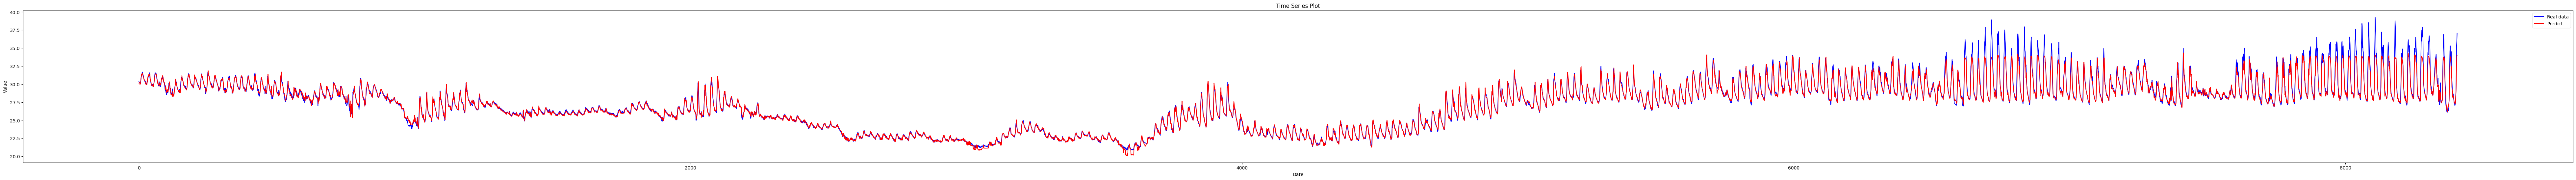

In [35]:
params = {
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'max_depth': 24,
    'learning_rate': 0.1,
    'subsample': 0.8
}
model_4 = xgb.XGBRegressor(**params)
model_4.fit(x_train,y_train)
y_predict = model_4.predict(x_test)
y_predict  = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

XGBoost 24 hours 48 max depth

In [36]:
time_step = 24

In [37]:
x_train, y_train = split_train(train.to_numpy(),time_step)
x_test, y_test = split_train(test.to_numpy(),time_step)

In [38]:
x_train = x_train.reshape(-1,time_step)
y_train = y_train.reshape(-1)
x_test = x_test.reshape(-1,time_step)
y_test = y_test.reshape(-1)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:359

e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
e:\EDUCATION\Bach Khoa University\HK223\Final Project\MFED_PythonService\venv\Lib\site-packages\xgboost\data.py:359

Mean Squared Error (MSE): 0.2921794028477119
Mean Absolute Error (MAE): 0.2876579122641015


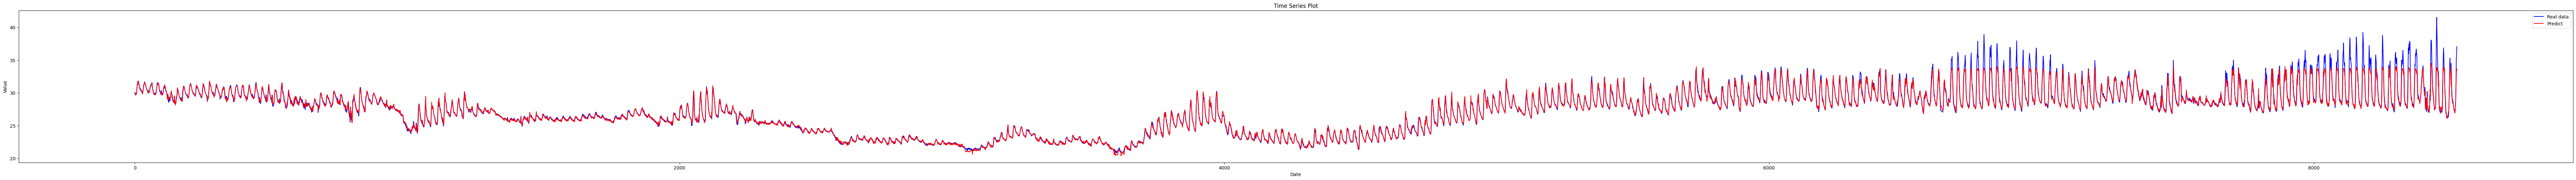

In [39]:
params = {
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'max_depth': 48,
    'learning_rate': 0.1,
    'subsample': 0.8
}
model_4 = xgb.XGBRegressor(**params)
model_4.fit(x_train,y_train)
y_predict = model_4.predict(x_test)
y_predict  = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()